In [3680]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.ardl import ARDL
from sklearn.model_selection import TimeSeriesSplit

In [3681]:
goods_df = pd.read_csv("../clean_data/global_commodity_prices.csv")
goods_df["Date"] = pd.to_datetime(goods_df["Date"], errors="coerce", format="%m/%Y")
goods_df["Date"] = pd.PeriodIndex(goods_df["Date"], freq="M")

In [3682]:
X = sm.add_constant(goods_df[["Tea", "Sugar"]])
Y = goods_df["Coffee"]

model = sm.OLS(Y, X).fit()

print(model.summary())

print(f"\nCoefficients:")
print(f"Intercept: {model.params["const"]}")
print(f"Coefficient for Tea: {model.params["Tea"]}")
print(f"Coefficient for Sugar (PSUGAISAUSDM): {model.params["Sugar"]}")
print(f"\nR-squared: {model.rsquared}")

                            OLS Regression Results                            
Dep. Variable:                 Coffee   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     336.3
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           7.49e-88
Time:                        20:06:19   Log-Likelihood:                -189.31
No. Observations:                 422   AIC:                             384.6
Df Residuals:                     419   BIC:                             396.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0248      0.079      0.313      0.7

In [3683]:
brl_df = pd.read_csv("../clean_data/brl_data_clean.csv")
vnd_df = pd.read_csv("../clean_data/vnd_data_clean.csv")
cop_df = pd.read_csv("../clean_data/cop_data_clean.csv")
idr_df = pd.read_csv("../clean_data/idr_data_clean.csv")
hnl_df = pd.read_csv("../clean_data/hnl_data_clean.csv")

xr_df = brl_df
for df in [vnd_df, cop_df, idr_df, hnl_df]:
    xr_df = pd.merge(xr_df, df, on="Date", how="inner")

xr_df["Date"] = pd.to_datetime(xr_df["Date"], errors="coerce", format="%m/%Y")
xr_df["Date"] = pd.PeriodIndex(xr_df["Date"], freq="M")

In [3684]:
merge_df = pd.merge(goods_df, xr_df, on="Date", how="inner")
merge_df["Time"] = merge_df["Date"]
merge_df["Time"] = merge_df["Time"].astype(str)
merge_df.set_index("Time",inplace=True)
merge_df = merge_df.drop(columns=["Date"])
merge_df

,Coffee,Milk,Sugar,Tea,brl Exchange Rate,vnd Exchange Rate,cop Exchange Rate,idr Exchange Rate,hnl Exchange Rate
Time,,,,,,,,,
1990-01,0.758300,NaN,0.142000,1.147273,0.000006,5479.329529,440.08,1804.850000,2.0000
1990-02,0.840100,NaN,0.146500,0.958396,0.000010,5479.329529,451.72,1809.870000,2.0000
1990-03,0.939600,NaN,0.153100,0.873620,0.000016,5479.329529,463.40,1820.350000,4.0000
1990-04,0.937300,NaN,0.152400,0.883644,0.000021,5479.329529,474.62,1826.050000,4.0000
1990-05,0.920200,NaN,0.146200,0.848309,0.000023,5563.430866,485.99,1831.400000,4.2000
...,...,...,...,...,...,...,...,...,...
2024-07,2.570987,0.242129,0.193517,1.363518,5.541448,24251.560000,4036.80,16261.652826,24.8582
2024-08,2.614377,0.244700,0.184195,1.467152,5.552014,24245.850000,4062.98,15793.181818,24.8826
2024-09,2.787605,0.251466,0.206248,1.572990,5.540967,24163.540000,4191.86,15341.250000,24.8381


In [3685]:
Z = sm.add_constant(merge_df[["Tea", "Sugar", "brl Exchange Rate", "vnd Exchange Rate", "cop Exchange Rate", 
                              "idr Exchange Rate", "hnl Exchange Rate"]])
W = merge_df["Coffee"]

model = sm.OLS(W, Z).fit()

print(model.summary())

print(f"\nCoefficients:")
print(f"Intercept: {model.params["const"]}")
print(f"Coefficient for tea (PTEAUSDM): {model.params["Tea"]}")
print(f"Coefficient for sugar (PSUGAISAUSDM): {model.params["Sugar"]}")
print(f"Coefficient for Brazil Exchange Rate: {model.params["brl Exchange Rate"]}")
print(f"Coefficient for Vietnam Exchange Rate: {model.params["vnd Exchange Rate"]}")
print(f"Coefficient for Colombia Exchange Rate: {model.params["cop Exchange Rate"]}")
print(f"Coefficient for Indonesia Exchange Rate: {model.params["idr Exchange Rate"]}")
print(f"Coefficient for Honduras Exchange Rate: {model.params["hnl Exchange Rate"]}")
print(f"\nR-squared: {model.rsquared}")

                            OLS Regression Results                            
Dep. Variable:                 Coffee   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     138.7
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          4.69e-104
Time:                        20:06:19   Log-Likelihood:                -114.01
No. Observations:                 419   AIC:                             244.0
Df Residuals:                     411   BIC:                             276.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2090      0.09

In [3686]:
result = adfuller(merge_df["Coffee"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -1.7881037924831735
P-Value: 0.3863836197218491


In [3687]:
merge_df["coffee_diff"] = merge_df["Coffee"].diff()

merge_df["coffee_diff"] = merge_df["coffee_diff"].replace([np.inf, -np.inf], np.nan)

merge_df = merge_df.dropna(subset=["coffee_diff"])

In [3688]:
result = adfuller(merge_df["coffee_diff"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -11.585252397836792
P-Value: 2.877944863970424e-21


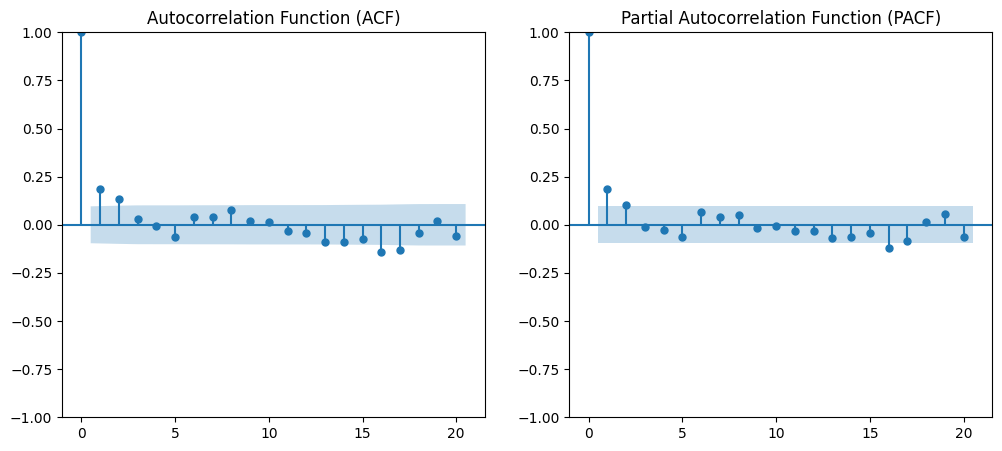

In [3689]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

plot_acf(merge_df["coffee_diff"], lags=20, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(merge_df["coffee_diff"], lags=20, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

<div align="center">
  ARMA(1,1) Model
</div>

In [3690]:
model = ARIMA(merge_df['coffee_diff'], order=(1, 1, 1))
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:            coffee_diff   No. Observations:                  418
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 338.275
Date:                Tue, 11 Mar 2025   AIC                           -670.551
Time:                        20:06:19   BIC                           -658.451
Sample:                    02-01-1990   HQIC                          -665.767
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1940      0.027      7.287      0.000       0.142       0.246
ma.L1         -0.9999      0.570     -1.755      0.079      -2.116       0.117
sigma2         0.0114      0.006      1.761      0.0

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\1140314688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["coffee_price_change"] = merge_df["coffee_diff"].cumsum()


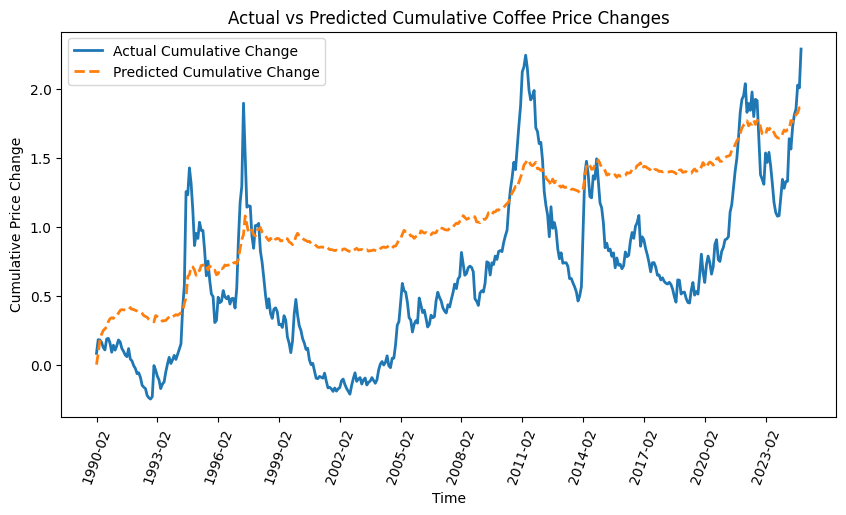

In [3691]:
merge_df["coffee_price_change"] = merge_df["coffee_diff"].cumsum()
predicted_returns = fitted_model.fittedvalues
predicted_returns = predicted_returns.cumsum()
plt.figure(figsize=(10,5))
plt.plot(merge_df.index, merge_df["coffee_price_change"], label="Actual Cumulative Change", linewidth=2)
plt.plot(merge_df.index, predicted_returns, label="Predicted Cumulative Change", linestyle="dashed", linewidth=2)
plt.legend()

tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)

plt.xlabel("Time")
plt.ylabel("Cumulative Price Change")
plt.title("Actual vs Predicted Cumulative Coffee Price Changes")

plt.show()

In [3692]:
mse = mean_squared_error(merge_df["coffee_price_change"], predicted_returns)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.3234


<div align="center">
  GARCH(1,1) Model
</div>

In [3821]:
returns = merge_df["coffee_diff"].dropna()

garch_model = arch_model(returns, vol="Garch", p=1, q=1)
garch_result = garch_model.fit(disp="off")

predicted_volatility = garch_result.conditional_volatility

X = sm.add_constant(predicted_volatility)
y = returns

garch_m_reg = sm.OLS(y, X).fit()
print(garch_m_reg.summary())

garch_m_predicted = garch_m_reg.predict(X)

returns_aligned = returns[-len(garch_m_predicted):]
garch_m_predicted = garch_m_predicted[-len(returns_aligned):]

returns_aligned = returns_aligned.dropna()
garch_m_predicted = garch_m_predicted.dropna()

cumulative_actual = returns_aligned.cumsum()
cumulative_predicted = garch_m_predicted.cumsum()

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                            OLS Regression Results                            
Dep. Variable:            coffee_diff   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.159
Date:                Tue, 11 Mar 2025   Prob (F-statistic):              0.142
Time:                        20:21:20   Log-Likelihood:                 335.82
No. Observations:                 418   AIC:                            -667.6
Df Residuals:                     416   BIC:                            -659.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0222      0.013      1.768      0.0

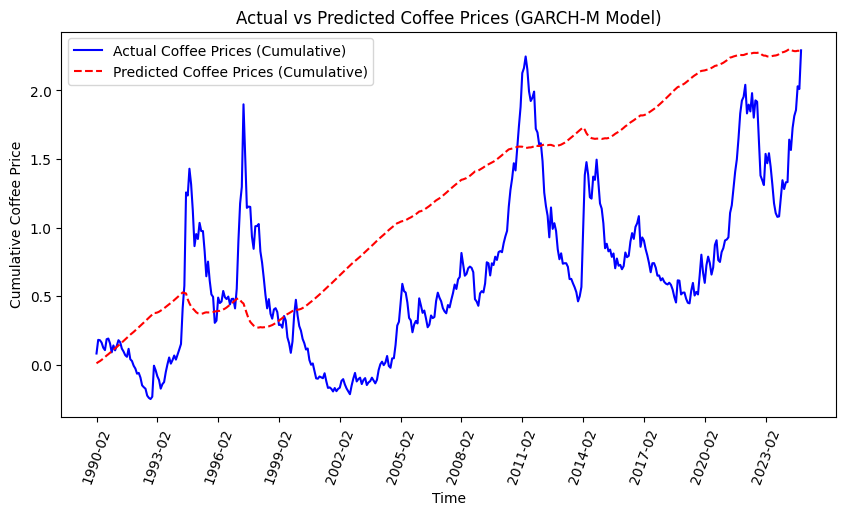

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_actual, label="Actual Coffee Prices (Cumulative)", color="blue")
plt.plot(cumulative_predicted, label="Predicted Coffee Prices (Cumulative)", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Cumulative Coffee Price")
plt.title("Actual vs Predicted Coffee Prices (GARCH Model)")
plt.legend()
tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)
plt.show()

In [ ]:
actual_values = merge_df["coffee_price_change"].dropna()

garch_m_mse = mean_squared_error(actual_values, garch_m_predicted)
print(f"GARCH Model MSE: {garch_m_mse:}")

GARCH Model MSE: 1.3189


<div align="center">
  GARCH-M(1,1) Model
</div>

In [3866]:
returns = merge_df["coffee_diff"].dropna()

# Step 2: Fit a GARCH model to get conditional volatility (predicted volatility)
garch_model = arch_model(returns, vol="Garch", p=1, q=1)
garch_result = garch_model.fit(disp="off")

# Step 3: Get the predicted conditional volatility from the GARCH model
predicted_volatility = garch_result.conditional_volatility

# Step 4: Add conditional volatility as part of the mean equation for GARCH-M
# We will include both constant and predicted volatility in the regression

X = sm.add_constant(predicted_volatility)  # Add constant and predicted volatility
y = returns

# Step 5: Fit the OLS regression for GARCH-M
garch_m_reg = sm.OLS(y, X).fit()

# Print the regression summary to inspect the coefficients
print(garch_m_reg.summary())

# Step 6: Get the predicted returns from the regression
garch_m_predicted = garch_m_reg.predict(X)

# Step 7: Align the actual returns with the predicted returns
returns_aligned = returns[-len(garch_m_predicted):]
garch_m_predicted = garch_m_predicted[-len(returns_aligned):]

# Drop NaN values if any exist
returns_aligned = returns_aligned.dropna()
garch_m_predicted = garch_m_predicted.dropna()

# Step 8: Calculate cumulative sums of actual and predicted returns
cumulative_actual = returns_aligned.cumsum()
cumulative_predicted = garch_m_predicted.cumsum()

                            OLS Regression Results                            
Dep. Variable:            coffee_diff   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.159
Date:                Tue, 11 Mar 2025   Prob (F-statistic):              0.142
Time:                        20:29:52   Log-Likelihood:                 335.82
No. Observations:                 418   AIC:                            -667.6
Df Residuals:                     416   BIC:                            -659.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0222      0.013      1.768      0.0

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


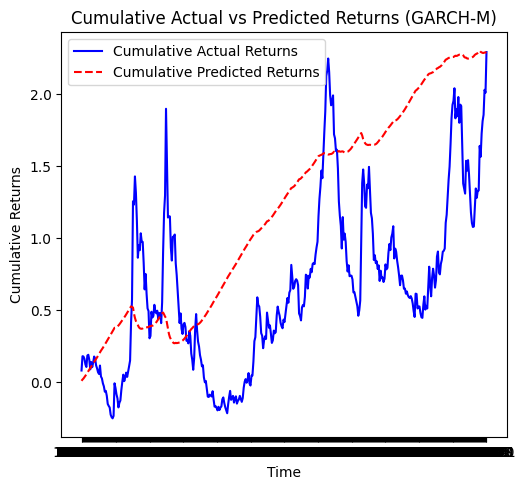

In [3867]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plt.plot(cumulative_actual, label="Cumulative Actual Returns", color="blue")
plt.plot(cumulative_predicted, label="Cumulative Predicted Returns", color="red", linestyle="--")
plt.title("Cumulative Actual vs Predicted Returns (GARCH-M)")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [3868]:
actual_values = merge_df["coffee_price_change"].dropna()

garch_m_mse = mean_squared_error(actual_values, garch_m_predicted)
print(f"GARCH-M Model MSE: {garch_m_mse:}")

GARCH-M Model MSE: 0.7634071805473287


<div align="center">
  ARDL(1,1) Model
</div>

In [3869]:
merge_df["tea_diff"] = merge_df["Tea"].diff().dropna()
merge_df["tea_diff"].dropna(inplace=True)

merge_df["sugar_diff"] = merge_df["Sugar"].diff().dropna()
merge_df["sugar_diff"].dropna(inplace=True)

merge_df["milk_diff"] = merge_df["Milk"].diff().dropna()
merge_df["sugar_diff"].dropna(inplace=True)

merge_df["brl_diff"] = merge_df["brl Exchange Rate"].diff().dropna()
merge_df["brl_diff"].dropna(inplace=True)

merge_df["vnd_diff"] = merge_df["vnd Exchange Rate"].diff().dropna()
merge_df["vnd_diff"].dropna(inplace=True)

merge_df["cop_diff"] = merge_df["cop Exchange Rate"].diff().dropna()
merge_df["cop_diff"].dropna(inplace=True)

merge_df["idr_diff"] = merge_df["idr Exchange Rate"].diff().dropna()
merge_df["idr_diff"].dropna(inplace=True)

merge_df["hnl_diff"] = merge_df["hnl Exchange Rate"].diff().dropna()
merge_df["hnl_diff"].dropna(inplace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3933167404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["tea_diff"] = merge_df["Tea"].diff().dropna()
C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3933167404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["tea_diff"].dropna(inplace=True)
C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3933167404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [3870]:
y = merge_df["coffee_diff"].dropna()
X = merge_df[["tea_diff", "sugar_diff", "milk_diff", "brl_diff", "vnd_diff", "cop_diff", 
                              "idr_diff", "hnl_diff"]].dropna()

In [3871]:
y, X = y.align(X, join="inner")

# Fit the ARDL model with y as the dependent variable and X as the exogenous variables
model = ARDL(y, lags=(1), exog=X, order=(1, 0))  # Define lag and exogenous variables
model_fitted = model.fit()

# Print the summary of the model
print(model_fitted.summary())

# Obtain the predicted values from the model
predicted_values = model_fitted.predict()

# Align the actual and predicted values (trim excess if necessary)
y_aligned = y[-len(predicted_values):]

# Drop NaN values from both actual and predicted values if any
y_aligned = y_aligned.dropna()
predicted_values = predicted_values.dropna()

# Ensure the lengths match after dropping NaN values
if len(y_aligned) != len(predicted_values):
    print(f"Length mismatch: y_aligned has {len(y_aligned)} values, predicted_values has {len(predicted_values)} values.")
else:
    # Step 1: Cumulative sum of the actual differenced values (y)
    cumulative_y = y_aligned.cumsum()

    # Step 2: Cumulative sum of the predicted differenced values
    cumulative_predicted = predicted_values.cumsum()

                                     ARDL Model Results                                    
Dep. Variable:                         coffee_diff   No. Observations:                  376
Model:             ARDL(1, 1, 1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 305.989
Method:                            Conditional MLE   S.D. of innovations              0.107
Date:                             Tue, 11 Mar 2025   AIC                           -573.978
Time:                                     20:29:53   BIC                           -499.367
Sample:                                 09-01-1993   HQIC                          -544.357
                                      - 11-01-2024                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0013      0.007      0.182      0.855      -0.013       0.016
coffee_diff.L1 

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3383358135.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(cumulative_predicted, label="Cumulative Predicted Coffee Price", color='red', linestyle='dashed', linewidth=2)


ConversionError: Failed to convert value(s) to axis units: array(['1993-08-01T00:00:00.000000000', '1993-09-01T00:00:00.000000000',
       '1993-10-01T00:00:00.000000000', '1993-11-01T00:00:00.000000000',
       '1993-12-01T00:00:00.000000000', '1994-01-01T00:00:00.000000000',
       '1994-02-01T00:00:00.000000000', '1994-03-01T00:00:00.000000000',
       '1994-04-01T00:00:00.000000000', '1994-05-01T00:00:00.000000000',
       '1994-06-01T00:00:00.000000000', '1994-07-01T00:00:00.000000000',
       '1994-08-01T00:00:00.000000000', '1994-09-01T00:00:00.000000000',
       '1994-10-01T00:00:00.000000000', '1994-11-01T00:00:00.000000000',
       '1994-12-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1995-02-01T00:00:00.000000000', '1995-03-01T00:00:00.000000000',
       '1995-04-01T00:00:00.000000000', '1995-05-01T00:00:00.000000000',
       '1995-06-01T00:00:00.000000000', '1995-07-01T00:00:00.000000000',
       '1995-08-01T00:00:00.000000000', '1995-09-01T00:00:00.000000000',
       '1995-10-01T00:00:00.000000000', '1995-11-01T00:00:00.000000000',
       '1995-12-01T00:00:00.000000000', '1996-01-01T00:00:00.000000000',
       '1996-02-01T00:00:00.000000000', '1996-03-01T00:00:00.000000000',
       '1996-04-01T00:00:00.000000000', '1996-05-01T00:00:00.000000000',
       '1996-06-01T00:00:00.000000000', '1996-07-01T00:00:00.000000000',
       '1996-08-01T00:00:00.000000000', '1996-09-01T00:00:00.000000000',
       '1996-10-01T00:00:00.000000000', '1996-11-01T00:00:00.000000000',
       '1996-12-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1997-02-01T00:00:00.000000000', '1997-03-01T00:00:00.000000000',
       '1997-04-01T00:00:00.000000000', '1997-05-01T00:00:00.000000000',
       '1997-06-01T00:00:00.000000000', '1997-07-01T00:00:00.000000000',
       '1997-08-01T00:00:00.000000000', '1997-09-01T00:00:00.000000000',
       '1997-10-01T00:00:00.000000000', '1997-11-01T00:00:00.000000000',
       '1997-12-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1998-02-01T00:00:00.000000000', '1998-03-01T00:00:00.000000000',
       '1998-04-01T00:00:00.000000000', '1998-05-01T00:00:00.000000000',
       '1998-06-01T00:00:00.000000000', '1998-07-01T00:00:00.000000000',
       '1998-08-01T00:00:00.000000000', '1998-09-01T00:00:00.000000000',
       '1998-10-01T00:00:00.000000000', '1998-11-01T00:00:00.000000000',
       '1998-12-01T00:00:00.000000000', '1999-01-01T00:00:00.000000000',
       '1999-02-01T00:00:00.000000000', '1999-03-01T00:00:00.000000000',
       '1999-04-01T00:00:00.000000000', '1999-05-01T00:00:00.000000000',
       '1999-06-01T00:00:00.000000000', '1999-07-01T00:00:00.000000000',
       '1999-08-01T00:00:00.000000000', '1999-09-01T00:00:00.000000000',
       '1999-10-01T00:00:00.000000000', '1999-11-01T00:00:00.000000000',
       '1999-12-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '2000-02-01T00:00:00.000000000', '2000-03-01T00:00:00.000000000',
       '2000-04-01T00:00:00.000000000', '2000-05-01T00:00:00.000000000',
       '2000-06-01T00:00:00.000000000', '2000-07-01T00:00:00.000000000',
       '2000-08-01T00:00:00.000000000', '2000-09-01T00:00:00.000000000',
       '2000-10-01T00:00:00.000000000', '2000-11-01T00:00:00.000000000',
       '2000-12-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2001-02-01T00:00:00.000000000', '2001-03-01T00:00:00.000000000',
       '2001-04-01T00:00:00.000000000', '2001-05-01T00:00:00.000000000',
       '2001-06-01T00:00:00.000000000', '2001-07-01T00:00:00.000000000',
       '2001-08-01T00:00:00.000000000', '2001-09-01T00:00:00.000000000',
       '2001-10-01T00:00:00.000000000', '2001-11-01T00:00:00.000000000',
       '2001-12-01T00:00:00.000000000', '2002-01-01T00:00:00.000000000',
       '2002-02-01T00:00:00.000000000', '2002-03-01T00:00:00.000000000',
       '2002-04-01T00:00:00.000000000', '2002-05-01T00:00:00.000000000',
       '2002-06-01T00:00:00.000000000', '2002-07-01T00:00:00.000000000',
       '2002-08-01T00:00:00.000000000', '2002-09-01T00:00:00.000000000',
       '2002-10-01T00:00:00.000000000', '2002-11-01T00:00:00.000000000',
       '2002-12-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2003-02-01T00:00:00.000000000', '2003-03-01T00:00:00.000000000',
       '2003-04-01T00:00:00.000000000', '2003-05-01T00:00:00.000000000',
       '2003-06-01T00:00:00.000000000', '2003-07-01T00:00:00.000000000',
       '2003-08-01T00:00:00.000000000', '2003-09-01T00:00:00.000000000',
       '2003-10-01T00:00:00.000000000', '2003-11-01T00:00:00.000000000',
       '2003-12-01T00:00:00.000000000', '2004-01-01T00:00:00.000000000',
       '2004-02-01T00:00:00.000000000', '2004-03-01T00:00:00.000000000',
       '2004-04-01T00:00:00.000000000', '2004-05-01T00:00:00.000000000',
       '2004-06-01T00:00:00.000000000', '2004-07-01T00:00:00.000000000',
       '2004-08-01T00:00:00.000000000', '2004-09-01T00:00:00.000000000',
       '2004-10-01T00:00:00.000000000', '2004-11-01T00:00:00.000000000',
       '2004-12-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2005-02-01T00:00:00.000000000', '2005-03-01T00:00:00.000000000',
       '2005-04-01T00:00:00.000000000', '2005-05-01T00:00:00.000000000',
       '2005-06-01T00:00:00.000000000', '2005-07-01T00:00:00.000000000',
       '2005-08-01T00:00:00.000000000', '2005-09-01T00:00:00.000000000',
       '2005-10-01T00:00:00.000000000', '2005-11-01T00:00:00.000000000',
       '2005-12-01T00:00:00.000000000', '2006-01-01T00:00:00.000000000',
       '2006-02-01T00:00:00.000000000', '2006-03-01T00:00:00.000000000',
       '2006-04-01T00:00:00.000000000', '2006-05-01T00:00:00.000000000',
       '2006-06-01T00:00:00.000000000', '2006-07-01T00:00:00.000000000',
       '2006-08-01T00:00:00.000000000', '2006-09-01T00:00:00.000000000',
       '2006-10-01T00:00:00.000000000', '2006-11-01T00:00:00.000000000',
       '2006-12-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2007-02-01T00:00:00.000000000', '2007-03-01T00:00:00.000000000',
       '2007-04-01T00:00:00.000000000', '2007-05-01T00:00:00.000000000',
       '2007-06-01T00:00:00.000000000', '2007-07-01T00:00:00.000000000',
       '2007-08-01T00:00:00.000000000', '2007-09-01T00:00:00.000000000',
       '2007-10-01T00:00:00.000000000', '2007-11-01T00:00:00.000000000',
       '2007-12-01T00:00:00.000000000', '2008-01-01T00:00:00.000000000',
       '2008-02-01T00:00:00.000000000', '2008-03-01T00:00:00.000000000',
       '2008-04-01T00:00:00.000000000', '2008-05-01T00:00:00.000000000',
       '2008-06-01T00:00:00.000000000', '2008-07-01T00:00:00.000000000',
       '2008-08-01T00:00:00.000000000', '2008-09-01T00:00:00.000000000',
       '2008-10-01T00:00:00.000000000', '2008-11-01T00:00:00.000000000',
       '2008-12-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2009-02-01T00:00:00.000000000', '2009-03-01T00:00:00.000000000',
       '2009-04-01T00:00:00.000000000', '2009-05-01T00:00:00.000000000',
       '2009-06-01T00:00:00.000000000', '2009-07-01T00:00:00.000000000',
       '2009-08-01T00:00:00.000000000', '2009-09-01T00:00:00.000000000',
       '2009-10-01T00:00:00.000000000', '2009-11-01T00:00:00.000000000',
       '2009-12-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2010-02-01T00:00:00.000000000', '2010-03-01T00:00:00.000000000',
       '2010-04-01T00:00:00.000000000', '2010-05-01T00:00:00.000000000',
       '2010-06-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2010-08-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000', '2010-11-01T00:00:00.000000000',
       '2010-12-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2011-02-01T00:00:00.000000000', '2011-03-01T00:00:00.000000000',
       '2011-04-01T00:00:00.000000000', '2011-05-01T00:00:00.000000000',
       '2011-06-01T00:00:00.000000000', '2011-07-01T00:00:00.000000000',
       '2011-08-01T00:00:00.000000000', '2011-09-01T00:00:00.000000000',
       '2011-10-01T00:00:00.000000000', '2011-11-01T00:00:00.000000000',
       '2011-12-01T00:00:00.000000000', '2012-01-01T00:00:00.000000000',
       '2012-02-01T00:00:00.000000000', '2012-03-01T00:00:00.000000000',
       '2012-04-01T00:00:00.000000000', '2012-05-01T00:00:00.000000000',
       '2012-06-01T00:00:00.000000000', '2012-07-01T00:00:00.000000000',
       '2012-08-01T00:00:00.000000000', '2012-09-01T00:00:00.000000000',
       '2012-10-01T00:00:00.000000000', '2012-11-01T00:00:00.000000000',
       '2012-12-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2013-02-01T00:00:00.000000000', '2013-03-01T00:00:00.000000000',
       '2013-04-01T00:00:00.000000000', '2013-05-01T00:00:00.000000000',
       '2013-06-01T00:00:00.000000000', '2013-07-01T00:00:00.000000000',
       '2013-08-01T00:00:00.000000000', '2013-09-01T00:00:00.000000000',
       '2013-10-01T00:00:00.000000000', '2013-11-01T00:00:00.000000000',
       '2013-12-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000',
       '2014-02-01T00:00:00.000000000', '2014-03-01T00:00:00.000000000',
       '2014-04-01T00:00:00.000000000', '2014-05-01T00:00:00.000000000',
       '2014-06-01T00:00:00.000000000', '2014-07-01T00:00:00.000000000',
       '2014-08-01T00:00:00.000000000', '2014-09-01T00:00:00.000000000',
       '2014-10-01T00:00:00.000000000', '2014-11-01T00:00:00.000000000',
       '2014-12-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000',
       '2015-02-01T00:00:00.000000000', '2015-03-01T00:00:00.000000000',
       '2015-04-01T00:00:00.000000000', '2015-05-01T00:00:00.000000000',
       '2015-06-01T00:00:00.000000000', '2015-07-01T00:00:00.000000000',
       '2015-08-01T00:00:00.000000000', '2015-09-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000', '2015-11-01T00:00:00.000000000',
       '2015-12-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2016-02-01T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '2016-04-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2016-06-01T00:00:00.000000000', '2016-07-01T00:00:00.000000000',
       '2016-08-01T00:00:00.000000000', '2016-09-01T00:00:00.000000000',
       '2016-10-01T00:00:00.000000000', '2016-11-01T00:00:00.000000000',
       '2016-12-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000',
       '2017-02-01T00:00:00.000000000', '2017-03-01T00:00:00.000000000',
       '2017-04-01T00:00:00.000000000', '2017-05-01T00:00:00.000000000',
       '2017-06-01T00:00:00.000000000', '2017-07-01T00:00:00.000000000',
       '2017-08-01T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2017-11-01T00:00:00.000000000',
       '2017-12-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-02-01T00:00:00.000000000', '2018-03-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-05-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-02-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2021-05-01T00:00:00.000000000',
       '2021-06-01T00:00:00.000000000', '2021-07-01T00:00:00.000000000',
       '2021-08-01T00:00:00.000000000', '2021-09-01T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
       '2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2022-03-01T00:00:00.000000000',
       '2022-04-01T00:00:00.000000000', '2022-05-01T00:00:00.000000000',
       '2022-06-01T00:00:00.000000000', '2022-07-01T00:00:00.000000000',
       '2022-08-01T00:00:00.000000000', '2022-09-01T00:00:00.000000000',
       '2022-10-01T00:00:00.000000000', '2022-11-01T00:00:00.000000000',
       '2022-12-01T00:00:00.000000000', '2023-01-01T00:00:00.000000000',
       '2023-02-01T00:00:00.000000000', '2023-03-01T00:00:00.000000000',
       '2023-04-01T00:00:00.000000000', '2023-05-01T00:00:00.000000000',
       '2023-06-01T00:00:00.000000000', '2023-07-01T00:00:00.000000000',
       '2023-08-01T00:00:00.000000000', '2023-09-01T00:00:00.000000000',
       '2023-10-01T00:00:00.000000000', '2023-11-01T00:00:00.000000000',
       '2023-12-01T00:00:00.000000000', '2024-01-01T00:00:00.000000000',
       '2024-02-01T00:00:00.000000000', '2024-03-01T00:00:00.000000000',
       '2024-04-01T00:00:00.000000000', '2024-05-01T00:00:00.000000000',
       '2024-06-01T00:00:00.000000000', '2024-07-01T00:00:00.000000000',
       '2024-08-01T00:00:00.000000000', '2024-09-01T00:00:00.000000000',
       '2024-10-01T00:00:00.000000000', '2024-11-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

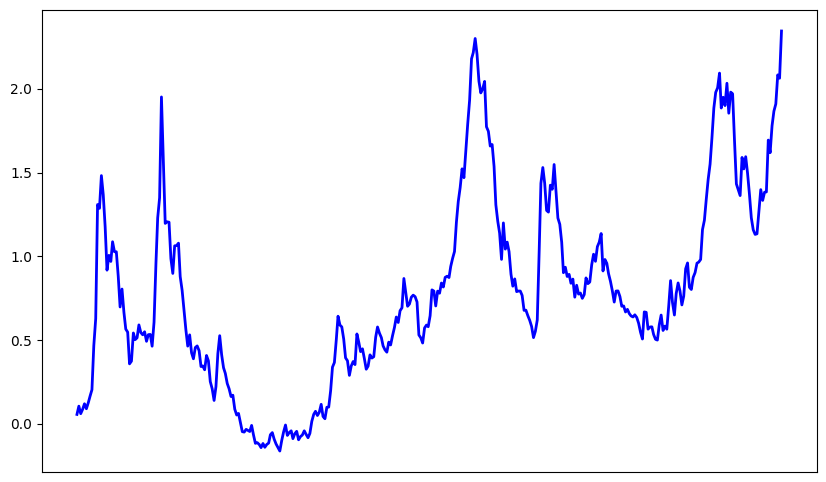

In [3872]:
plt.figure(figsize=(10, 6))

plt.plot(cumulative_y, label="Cumulative Actual Coffee Price", color='blue', linewidth=2)
plt.plot(cumulative_predicted, label="Cumulative Predicted Coffee Price", color='red', linestyle='dashed', linewidth=2)

plt.title("Cumulative Sum of Actual vs Predicted Coffee Prices ARDL Using (1,1)")
plt.xlabel("Time")
plt.ylabel("Cumulative Coffee Price Change")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(y_aligned.index)
print(predicted_values.index)

Index(['1993-08', '1993-09', '1993-10', '1993-11', '1993-12', '1994-01',
       '1994-02', '1994-03', '1994-04', '1994-05',
       ...
       '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07',
       '2024-08', '2024-09', '2024-10', '2024-11'],
      dtype='object', name='Time', length=376)
DatetimeIndex(['1993-09-01', '1993-10-01', '1993-11-01', '1993-12-01',
               '1994-01-01', '1994-02-01', '1994-03-01', '1994-04-01',
               '1994-05-01', '1994-06-01',
               ...
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01'],
              dtype='datetime64[ns]', length=375, freq='MS')


In [ ]:
mse = mean_squared_error(y_aligned, predicted_values)
print(f"Mean Squared Error (MSE) of Differenced Values: {mse:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [376, 375]

<div align="center">
  ARIMA(1,1) Model Forecasting
</div>

In [ ]:
model = ARIMA(merge_df['coffee_diff'], order=(1, 1, 1))
fitted_model = model.fit()

forecasted_values = fitted_model.forecast(steps=36)

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


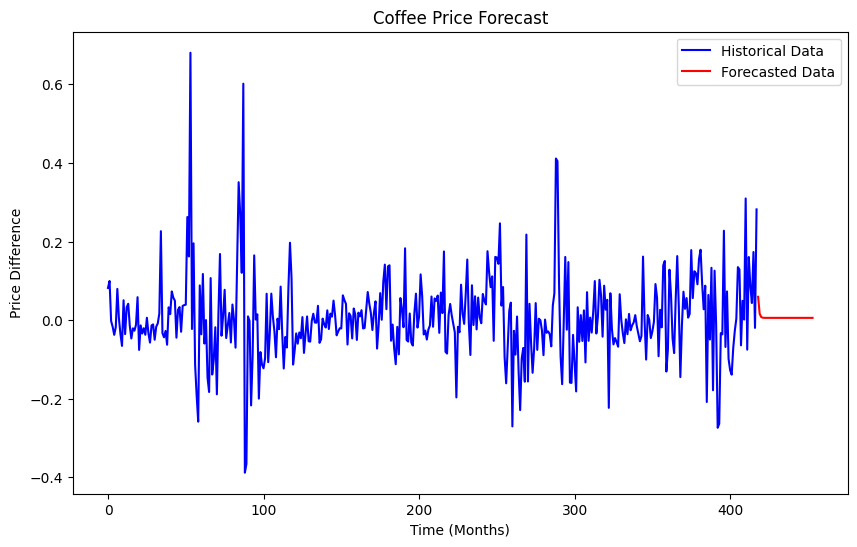

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(range(len(merge_df['coffee_diff'])), merge_df['coffee_diff'], label='Historical Data', color='blue')

plt.plot(range(len(merge_df['coffee_diff']), len(merge_df['coffee_diff']) + 36), forecasted_values, label='Forecasted Data', color='red')

plt.title('Coffee Price Forecast')
plt.xlabel('Time (Months)')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(merge_df['coffee_diff'], fitted_model.fittedvalues)
print(f'Mean Squared Error (MSE) of the model: {mse}')

Mean Squared Error (MSE) of the model: 0.011505280951172415


<div align="center">
  GARCH(1,1) Model Forecasting
</div>

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7894324.793709117
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16895.654832663527
Iteration:      3,   Func. Count:     23,   Neg. LLF: -355.0301763545035
Iteration:      4,   Func. Count:     30,   Neg. LLF: -84.29212852544927
Iteration:      5,   Func. Count:     37,   Neg. LLF: -345.8172147742008
Iteration:      6,   Func. Count:     43,   Neg. LLF: -389.80691297734666
Iteration:      7,   Func. Count:     50,   Neg. LLF: -390.88250149600265
Iteration:      8,   Func. Count:     55,   Neg. LLF: -390.8825420423191
Iteration:      9,   Func. Count:     59,   Neg. LLF: -390.8825420424929
Optimization terminated successfully    (Exit mode 0)
            Current function value: -390.8825420423191
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


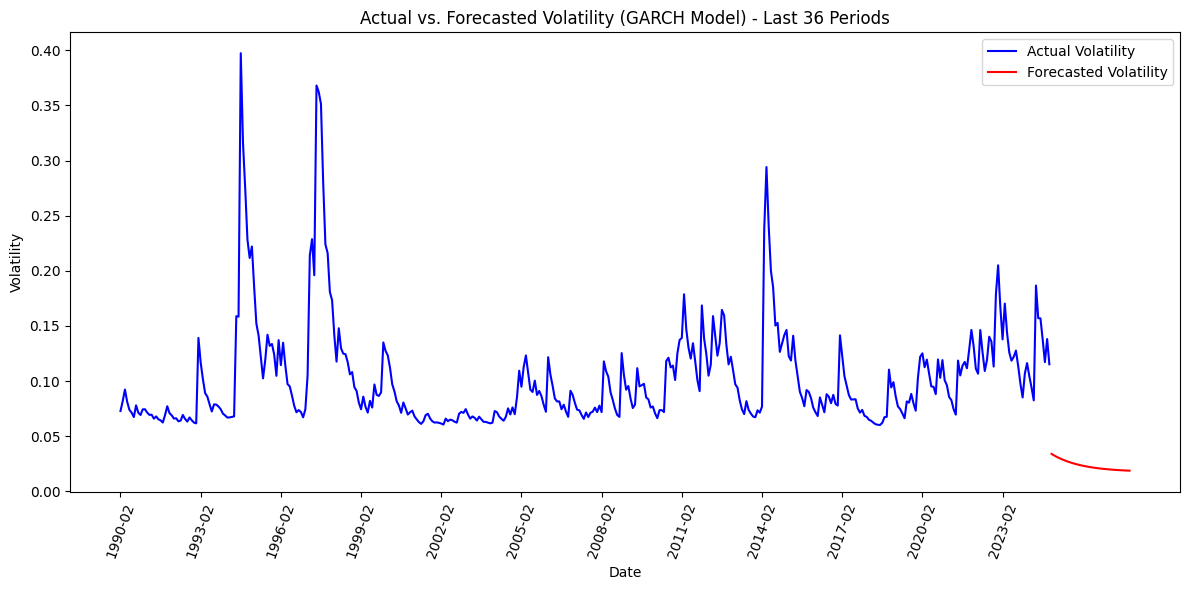

In [ ]:
returns = merge_df['coffee_diff'].dropna()
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

# Predicted volatility (conditional volatility)
predicted_volatility = garch_result.conditional_volatility

# Forecast the next 36 periods
forecast_horizon = 36
garch_forecast = garch_result.forecast(horizon=forecast_horizon)

# Forecasted volatility for the next 36 periods
forecasted_volatility = garch_forecast.variance.values[-1, :]

# Plot actual vs forecasted volatility
plt.figure(figsize=(12, 6))

# Plot actual volatility (conditional volatility)
plt.plot(merge_df.index, predicted_volatility, label="Actual Volatility", color='blue')

# Plot forecasted volatility for the last 36 periods
plt.plot(range(len(merge_df), len(merge_df) + forecast_horizon), forecasted_volatility, label="Forecasted Volatility", color='red')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Actual vs. Forecasted Volatility (GARCH Model) - Last 36 Periods")
plt.legend()

# Customize x-axis ticks
tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)

plt.tight_layout()
plt.show()

In [ ]:
mse = mean_squared_error(merge_df["coffee_diff"].iloc[-36:], forecasted_volatility)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.019094504844984192


<div align="center">
  GARCH-M(1,1) Model Forecasting
</div>

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1630969.266851986
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6586.985385782638
Iteration:      3,   Func. Count:     22,   Neg. LLF: -61.17278805866465
Iteration:      4,   Func. Count:     28,   Neg. LLF: -53.459081527280276
Iteration:      5,   Func. Count:     34,   Neg. LLF: -14.815797658537724
Iteration:      6,   Func. Count:     40,   Neg. LLF: -58.41839803315103
Iteration:      7,   Func. Count:     46,   Neg. LLF: -65.59399272990774
Iteration:      8,   Func. Count:     51,   Neg. LLF: -59.57834993613347
Iteration:      9,   Func. Count:     57,   Neg. LLF: -65.82013413986209
Iteration:     10,   Func. Count:     62,   Neg. LLF: -65.82460519863055
Iteration:     11,   Func. Count:     67,   Neg. LLF: -65.83094180502104
Iteration:     12,   Func. Count:     72,   Neg. LLF: -65.83112609849093
Iteration:     13,   Func. Count:     77,   Neg. LLF: -65.83114497496388
Iteration:     14,   Func. Count:     81,   Neg. LL

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData

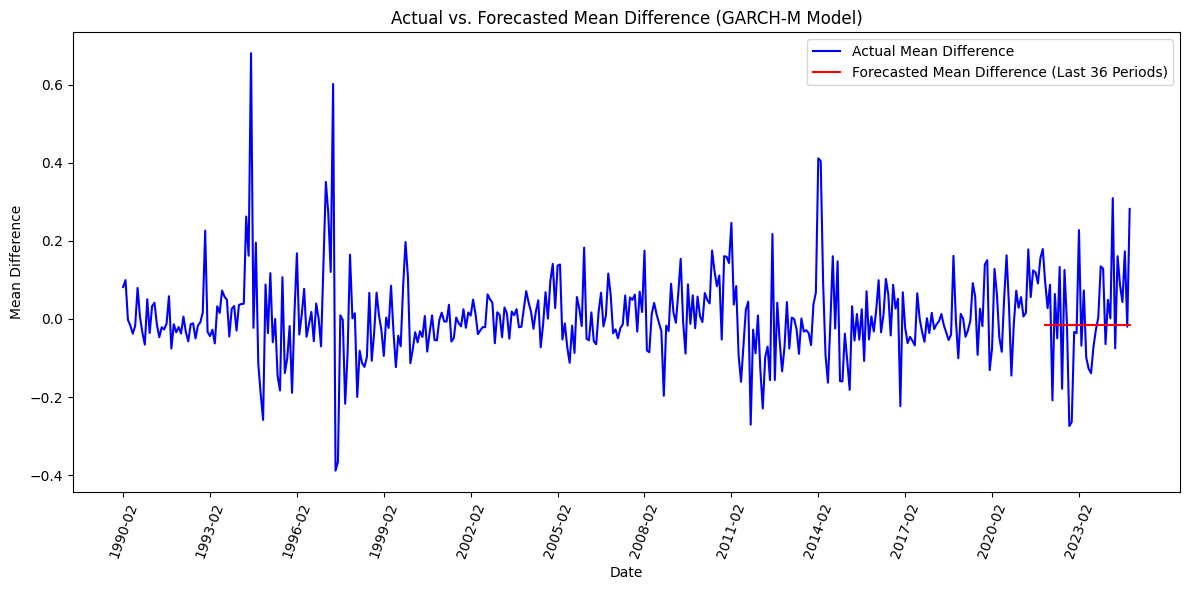

In [ ]:
returns = merge_df['coffee_diff'].dropna()

tscv = TimeSeriesSplit(n_splits=5)

predictions = []
actual_data = returns[-36:]

for train_index, test_index in tscv.split(returns[:-36]):
    train_data, test_data = returns.iloc[train_index], returns.iloc[test_index]
    
    garch_m_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant')
    garch_m_result = garch_m_model.fit()

    garch_m_forecast = garch_m_result.forecast(horizon=36)
    forecasted_mean = garch_m_forecast.mean.values[-1, :]
    
    predictions.append(forecasted_mean)

predicted_mean = predictions[0]

plt.figure(figsize=(12, 6))

plt.plot(returns.index, returns, label="Actual Mean Difference", color='blue')

plt.plot(actual_data.index, predicted_mean, label="Forecasted Mean Difference (Last 36 Periods)", color='red')

plt.xlabel("Date")
plt.ylabel("Mean Difference")
plt.title("Actual vs. Forecasted Mean Difference (GARCH-M Model)")
plt.legend()

tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)

plt.tight_layout()
plt.show()

In [ ]:
mse = mean_squared_error(actual_data, predicted_mean)
print(f"Mean Squared Error for the last 36 periods: {mse}")

Mean Squared Error for the last 36 periods: 0.01948685133708334


<div align="center">
  ARDL(1,1) Model Forecasting
</div>

In [ ]:
y = merge_df["coffee_diff"].dropna()
X = merge_df[["tea_diff", "sugar_diff", "brl_diff", "vnd_diff", "cop_diff", 
                              "idr_diff", "hnl_diff"]].dropna()

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes,

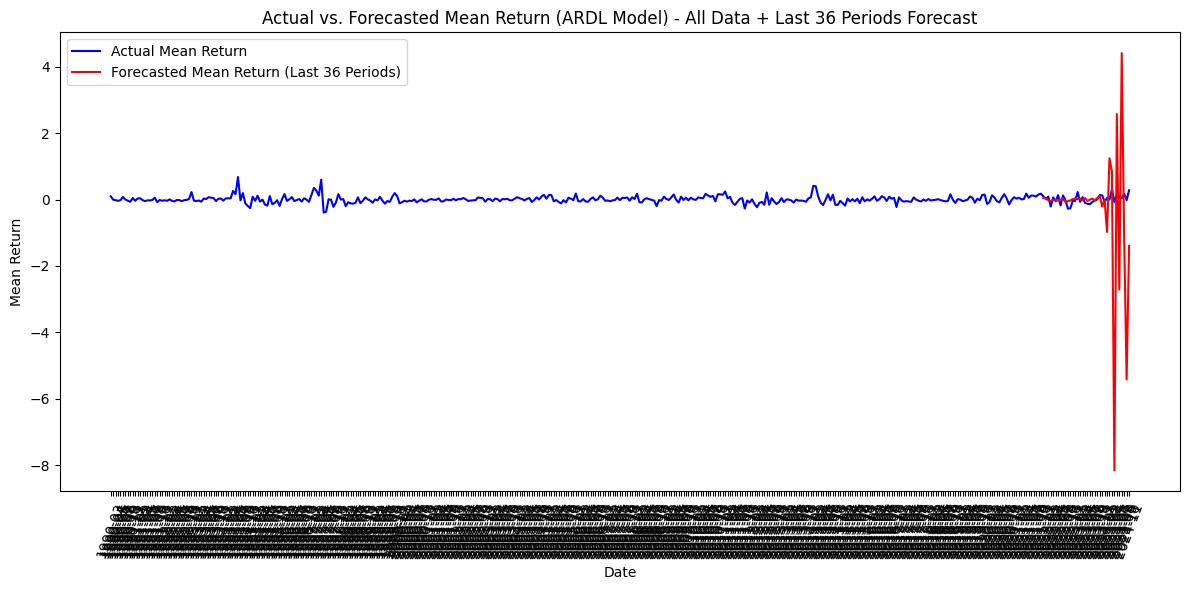

In [ ]:
y, X = y.align(X, join="inner")

tscv = TimeSeriesSplit(n_splits=5)

predictions = []
actual_data = y[-36:]

for train_index, test_index in tscv.split(y[:-36]):
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    
    model = ARDL(train_y, lags=(1), exog=train_X, order=(1, 0))
    model_fitted = model.fit()

    forecast = model_fitted.predict(start=len(train_y), end=len(train_y) + 35, exog_oos=test_X)

    predictions.append(forecast)

predicted_mean = predictions[0]

plt.figure(figsize=(12, 6))

plt.plot(y.index, y, label="Actual Mean Return", color='blue')

plt.plot(actual_data.index, predicted_mean, label="Forecasted Mean Return (Last 36 Periods)", color='red')

plt.xlabel("Date")
plt.ylabel("Mean Return")
plt.title("Actual vs. Forecasted Mean Return (ARDL Model) - All Data + Last 36 Periods Forecast")
plt.legend()

plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

In [ ]:
mse = mean_squared_error(y[-36:], forecast_values)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.018286240961027593
